# Lidar - GEDI
### Download GEDI data script

-----

>Rob Burger

>Space4Good

>Biomass estimation in Tanzania

Source

https://github.com/ornldaac/gedi_tutorials

In [ ]:
from osgeo import gdal

In [ ]:
import folium
import owslib.wcs as wcs
import owslib.wms as wms
import pandas as pd
import geopandas as gpd
import requests as re

import rasterio as rio
#from osgeo import gdal

import numpy as np
import matplotlib.pyplot as plt
from folium.plugins import FloatImage
from rasterstats import zonal_stats
from rasterio.plot import show

In [ ]:
import requests

doi = '10.3334/ORNLDAAC/2056'# GEDI L4A DOI 

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi
concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']
print(concept_id)

### Define Study Area

Read here the study area for which GEDI data should be downloaded

,minx,miny,maxx,maxy
0,30.52044,-1.826,31.220396,-1.084886


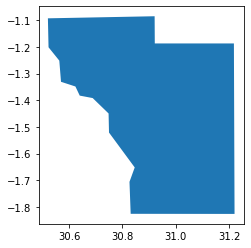

In [22]:
gdf = gpd.read_file("../../../data/Tanzania/extentNew2.shp")
xmin, ymin, xmax, ymax = gdf.total_bounds
gdf.plot()
gdf.geometry.bounds

In [ ]:
# orienting coordinates clockwise
from shapely.ops import orient

#print(gdf.geometry)
gdf.geometry = gdf.geometry.apply(orient, args=(1,))
print(gdf.geometry[0:5])

In [ ]:
bound = gdf.total_bounds

### Define Timeframe

Define here the desired time period for which GEDI data can be downloaded

In [ ]:
import datetime as dt
start_date = dt.datetime(2020, 10, 1) # specify your own start date
end_date = dt.datetime(2021, 12, 31)  # specify your own end date

### Search GEDI database

Code below searches for GEDI data (in granules) and outputs the data size

NASA's EarthData API is used

In [ ]:
import requests
from shapely.geometry import MultiPolygon, Polygon
import pandas as pd

# CMR formatted start and end times
dt_format = '%Y-%m-%dT%H:%M:%SZ'
temporal_str = start_date.strftime(dt_format) + ',' + end_date.strftime(dt_format)

# CMR formatted bounding box
bound_str = ','.join(map(str, bound))



doi = '10.3334/ORNLDAAC/2056'# GEDI L4A DOI 

# CMR API base url
cmrurl='https://cmr.earthdata.nasa.gov/search/' 

doisearch = cmrurl + 'collections.json?doi=' + doi
concept_id = requests.get(doisearch).json()['feed']['entry'][0]['id']

geojson = {"shapefile": ("amapa.geojson", gdf.geometry.to_json(), "application/geo+json")}

page_num = 1
page_size = 2000 # CMR page size limit

granule_arr = []

while True:
    
     # defining parameters
    cmr_param = {
        "collection_concept_id": concept_id, 
        "page_size": page_size,
        "page_num": page_num,
        "temporal": temporal_str,
        "bounding_box[]": bound_str,
        "simplify-shapefile": 'true' # this is needed to bypass 5000 coordinates limit of CMR
    }
    
    granulesearch = cmrurl + 'granules.json'
    response = requests.post(granulesearch, data=cmr_param, files=geojson)
#     print(response.json())
#     print(geojson)
    granules = response.json()['feed']['entry']
       
    if granules:
        for g in granules:
            granule_url = ''
            granule_poly = ''
                       
            # read file size
            granule_size = float(g['granule_size'])
    
            # reading bounding geometries
            if 'polygons' in g:
                polygons= g['polygons']
                multipolygons = []
                for poly in polygons:
                    i=iter(poly[0].split (" "))
                    ltln = list(map(" ".join,zip(i,i)))
                    multipolygons.append(Polygon([[float(p.split(" ")[1]), float(p.split(" ")[0])] for p in ltln]))
                granule_poly = MultiPolygon(multipolygons)
            
            # Get URL to HDF5 files
            for links in g['links']:
                if 'title' in links and links['title'].startswith('Download') \
                and links['title'].endswith('.h5'):
                    granule_url = links['href']
            granule_arr.append([granule_url, granule_size, granule_poly])
               
        page_num += 1
    else: 
        break



# adding bound as the last row into the dataframe
# we will use this later in the plot
granule_arr.append(['gdf', 0, gdf.iloc[0]["geometry"]]) 

# creating a pandas dataframe
l4adf = pd.DataFrame(granule_arr, columns=["granule_url", "granule_size", "granule_poly"])

# Drop granules with empty geometry
l4adf = l4adf[l4adf['granule_poly'] != '']

print ("Total granules found: ", len(l4adf.index)-1 )
print ("Total file size (MB): ", l4adf['granule_size'].sum())

In [ ]:
# Let's plot the GEDI data on top of the Study Area
# Just to check if it matches well

gdf = geopandas.GeoDataFrame(l4adf, geometry=l4adf.granule_poly)
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
base = world.plot(color='white', edgecolor='black', figsize  = (7, 7))

# last row contains the bounding box (Red)
ax= gdf[-1:].plot(ax=base, color='red', edgecolor='red', alpha=0.2)

# all but the last row contains granule bounding geometry (Green)
ax= gdf[:-1].plot(ax=base, color='green', edgecolor='green', alpha=0.2)

minx, miny, maxx, maxy = gdf[-1:].geometry.total_bounds
ax.set_xlim(minx-0.25, maxx+0.25)
ax.set_ylim(miny-0.25, maxy+0.25)

In [ ]:
# Save all the GEDI data granules in txt format
# This txt file can be used to download all the GEDI data

l4a_granules = l4adf[:-1].drop_duplicates(subset=['granule_url'])
l4a_granules.to_csv('../../data/processed/subsets/extentNew/granules.txt', columns = ['granule_url'], index=False, header = False)

In [ ]:
l4adf["granule_url"]

# Downloading the GEDI data

To continue the downloading process, switch to the terminal to download all the GEDI granules

---

#### Next steps according to the tutorial:

We recommend using utilities such as cURL or wget to download the files. You will first need to set up NASA Earthdata Login authentication using .netrc file. Please refer to this page for details on setting up such authentication: https://wiki.earthdata.nasa.gov/display/EL/How+To+Access+Data+With+cURL+And+Wget.

Once the authentication has been setup (Steps 1-3 on the above page), the GEDI L4a files can be downloaded as follows.

Either of the following commands can then be issued from the terminal to download the files.

#### wget

    wget --load-cookies ~/.urs_cookies --save-cookies ~/.urs_cookies --auth-no-challenge=on --keep-session-cookies --content-disposition -nc -i granules.txt

#### curl

    cat granules.txt | tr -d '\r' | xargs -n 1 curl -LJO -n -c ~/.urs_cookies -b ~/.urs_cookies


Be aware: "granules.txt" file should refer to the correct path

---

### After downloading the GEDI data...

Now that the GEDI data has been downloaded as .h5 files, some last processing steps should be done

We will now loop over each of these files and create a clipped version of the files into a new directory.

In [ ]:
from glob import glob
from os import path
import h5py
import numpy as np

indir = '../../../data/processed/subsets/extentNew/'
outdir = '../../../data/processed/subsets/extentNew/after/'

# converting to WGS84 coordinate system
#grsm_epsg4326 = gdf.to_crs(epsg=4326)
grsm_epsg4326 = gdf.set_crs(epsg=4326)

for infile in glob(path.join(indir, 'GEDI04_A*.h5')):
    name, ext = path.splitext(path.basename(infile))
    subfilename = "{name}_sub{ext}".format(name=name, ext=ext)
    outfile = path.join(outdir, path.basename(subfilename))
    hf_in = h5py.File(infile, 'r')
    hf_out = h5py.File(outfile, 'w')
    
    # copy ANCILLARY and METADATA groups
    var1 = ["/ANCILLARY", "/METADATA"]
    for v in var1:
        hf_in.copy(hf_in[v],hf_out)
    
    # loop through BEAMXXXX groups
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            # find the shots that overlays the area of interest (GRSM)
            lat = beam['lat_lowestmode'][:]
            lon = beam['lon_lowestmode'][:]
            i = np.arange(0, len(lat), 1) # index
            geo_arr = list(zip(lat,lon, i))
            l4adf = pd.DataFrame(geo_arr, columns=["lat_lowestmode", "lon_lowestmode", "i"])
            l4agdf = gpd.GeoDataFrame(l4adf, geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))
            l4agdf.crs = "EPSG:4326"
            l4agdf_gsrm = l4agdf[l4agdf['geometry'].within(grsm_epsg4326.geometry[0])]  
            indices = l4agdf_gsrm.i

            # copy BEAMS to the output file
            for key, value in beam.items():
                if isinstance(value, h5py.Group):
                    for key2, value2 in value.items():
                        group_path = value2.parent.name
                        group_id = hf_out.require_group(group_path)
                        dataset_path = group_path + '/' + key2
                        hf_out.create_dataset(dataset_path, data=value2[:][indices])
                        for attr in value2.attrs.keys():
                            hf_out[dataset_path].attrs[attr] = value2.attrs[attr]
                else:
                    group_path = value.parent.name
                    group_id = hf_out.require_group(group_path)
                    dataset_path = group_path + '/' + key
                    hf_out.create_dataset(dataset_path, data=value[:][indices])
                    for attr in value.attrs.keys():
                        hf_out[dataset_path].attrs[attr] = value.attrs[attr]

    hf_in.close()
    hf_out.close()

In [ ]:
lat_l = []
lon_l = []
agbd = []
outdir = '../../../data/processed/subsets/extentNew/after/'
for subfile in glob(path.join(outdir, 'GEDI04_A*.h5')):
    hf_in = h5py.File(subfile, 'r')
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            beam = hf_in[v]
            lat_l.extend(beam['lat_lowestmode'][:].tolist()) 
            lon_l.extend(beam['lon_lowestmode'][:].tolist()) 
            agbd.extend(beam['agbd'][:].tolist())
    hf_in.close()
geo_arr = list(zip(agbd,lat_l,lon_l))
df = pd.DataFrame(geo_arr, columns=["agbd", "lat_lowestmode", "lon_lowestmode"])
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon_lowestmode, df.lat_lowestmode))
gdf

<AxesSubplot:>

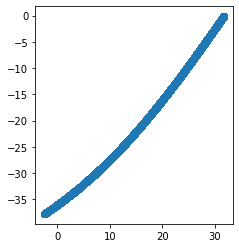

In [21]:
gdf.plot()

### Create subset of GEDI data based on time periods

Some GEDI files only contain -9999 samples, and thus are useless.

Therefore here carefully determine from which period GEDI data should be used

In [37]:
outdir

'../../../data/processed/subsets/extentNew/after/'

In [41]:
[*(glob(path.join(outdir, 'GEDI04_A_202*_sub.h5')))]

['../../../data/processed/subsets/extentNew/after\\GEDI04_A_2020275085922_O10216_01_T11118_02_002_02_V002_sub.h5',
 '../../../data/processed/subsets/extentNew/after\\GEDI04_A_2020283055351_O10338_01_T09389_02_002_02_V002_sub.h5',
 '../../../data/processed/subsets/extentNew/after\\GEDI04_A_2020291024541_O10460_01_T08272_02_002_02_V002_sub.h5',
 '../../../data/processed/subsets/extentNew/after\\GEDI04_A_2020295011133_O10521_01_T09695_02_002_02_V002_sub.h5',
 '../../../data/processed/subsets/extentNew/after\\GEDI04_A_2020298233723_O10582_01_T07002_02_002_02_V002_sub.h5',
 '../../../data/processed/subsets/extentNew/after\\GEDI04_A_2020302220309_O10643_01_T05732_02_002_02_V002_sub.h5',
 '../../../data/processed/subsets/extentNew/after\\GEDI04_A_2020306080550_O10696_04_T10452_02_002_02_V002_sub.h5',
 '../../../data/processed/subsets/extentNew/after\\GEDI04_A_2020310063128_O10757_04_T09182_02_002_02_V002_sub.h5',
 '../../../data/processed/subsets/extentNew/after\\GEDI04_A_2020314045702_O10818

In [ ]:
#2020 294 Oktober
#2021 015 Januari
#2021 023 Januari
#2021 027 Januari
#2021 089 30 Maart
#2021 093 3 April

# looks like there are only 7 gedi samples in these h5 files...

# better to use the whole time period... but super strange that GEDI has a super poor revisit time.

Apparantly for the Tanzania case, there are limited GEDI samples available in my desired time period.

Therefore all GEDI data from October 2020 until end of 2021 was used

---

Now below: Add GEDI data to pandas dataframe

In [ ]:
from glob import glob
from os import path
import pandas as pd
import h5py

outdir = '../../data/processed/subsets/extentNew/after/'
subset_df = pd.DataFrame()

i=0
# for subfile in glob(path.join(outdir, 'GEDI04_A_20202*_sub.h5')):
for subfile in glob(path.join(outdir, 'GEDI04_A*_sub.h5')):
# for subfile in [*(glob(path.join(outdir, 'GEDI04_A_2020294*_sub.h5'))), *(glob(path.join(outdir, 'GEDI04_A_20210*_sub.h5')))]:
    
    print(subfile)
    
    
    hf_in = h5py.File(subfile, 'r')
    for v in list(hf_in.keys()):
        if v.startswith('BEAM'):
            col_names = []
            col_val = []
            beam = hf_in[v]
            # copy BEAMS 
            for key, value in beam.items():
                # looping through subgroups
                if isinstance(value, h5py.Group):
                    for key2, value2 in value.items():
                        if (key2 != "shot_number"):
                             # xvar variables have 2D
                            if (key2.startswith('xvar')):
                                for r in range(4):
                                    col_names.append(key2 + '_' + str(r+1))
                                    col_val.append(value2[:, r].tolist())
                            else:
                                col_names.append(key2)
                                col_val.append(value2[:].tolist())
                
                #looping through base group
                else:
                    # xvar variables have 2D
                    if (key.startswith('xvar')):
                        for r in range(4):
                            col_names.append(key + '_' + str(r+1))
                            col_val.append(value[:, r].tolist())
                    else:
                        col_names.append(key)
                        col_val.append(value[:].tolist())
            
            # create a pandas dataframe        
            beam_df = pd.DataFrame(map(list, zip(*col_val)), columns=col_names) 
            # Inserting BEAM names
            beam_df.insert(0, 'BEAM', np.repeat(str(v), len(beam_df.index)).tolist())
            # Appending to the subset_df dataframe
            subset_df = subset_df.append(beam_df)
    hf_in.close()

In [ ]:
# Setting 'shot_number' as dataframe index. shot_number column is unique
#subset_df = subset_df.set_index('shot_number')
subset_df

# Export GEDI data

Can be stored in csv, geojson, or any other prefered output...

In [ ]:
subset_df.columns.tolist()

In [ ]:
subset_df = subset_df[["agbd","agbd_pi_lower","agbd_pi_upper","agbd_se","lon_lowestmode","lat_lowestmode"]]

In [ ]:
subset_df = subset_df[subset_df.agbd >= 0]
subset_df

In [ ]:
subset_gdf = gpd.GeoDataFrame(subset_df, geometry=gpd.points_from_xy(subset_df.lon_lowestmode, subset_df.lat_lowestmode))
subset_gdf.crs = "EPSG:4326"

# convert object types columns to strings. object types are not supported
for c in subset_gdf.columns:
    if subset_gdf[c].dtype == 'object':
        subset_gdf[c] = subset_gdf[c].astype(str)

# Export to GeoJSON
subset_gdf.to_file('../../data/processed/subsets/extentNew/grsm.geojson', driver='GeoJSON')